<a href="https://colab.research.google.com/github/DreamSki/DEAP--emotion-classifier/blob/main/Deap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 无用

In [ ]:
!wget -c http://www.eecs.qmul.ac.uk/mmv/datasets/deap/data/data_preprocessed_python.zip --http-user="li@digitalnature.slis.tsukuba.ac.jp" --http-password="SbVQZQ5h"

In [ ]:
!wget -c http://www.eecs.qmul.ac.uk/mmv/datasets/deap/data/data_original.zip --http-user="li@digitalnature.slis.tsukuba.ac.jp" --http-password="SbVQZQ5h" 

--2021-08-17 11:50:10--  http://www.eecs.qmul.ac.uk/mmv/datasets/deap/data/data_original.zip
Resolving www.eecs.qmul.ac.uk (www.eecs.qmul.ac.uk)... 138.37.95.147
Connecting to www.eecs.qmul.ac.uk (www.eecs.qmul.ac.uk)|138.37.95.147|:80... connected.
HTTP request sent, awaiting response... 401 Authorization Required
Authentication selected: Digest realm="DEAP", nonce="7W+L67/JBQA=6764748ba889ec8b1826b0c862fe30930585c41b", algorithm=MD5, domain="/data/", qop="auth"
Reusing existing connection to www.eecs.qmul.ac.uk:80.
HTTP request sent, awaiting response... 200 OK
Length: 6277320553 (5.8G) [application/zip]
Saving to: ‘data_original.zip’

data_original.zip   100%[===================>]   5.85G  29.8MB/s    in 3m 27s  

2021-08-17 11:53:38 (28.9 MB/s) - ‘data_original.zip’ saved [6277320553/6277320553]



In [ ]:
!git clone https://github.com/forrestbao/pyeeg.git

Cloning into 'pyeeg'...
remote: Enumerating objects: 207, done.
remote: Total 207 (delta 0), reused 0 (delta 0), pack-reused 207
Receiving objects: 100% (207/207), 118.02 KiB | 3.58 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [ ]:
!cd pyeeg

In [ ]:
!python setup.py install


# 引用

In [ ]:
import pyeeg as pe

In [ ]:

import numpy as np
#import pyeeg as pe
import pickle as pickle
import pandas as pd
import math

from sklearn import svm
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

import os
#import tensorflow as tf
import time

In [ ]:
cd ..

/


Channel Indice: {

- 1 : AF3; 2: F3; 3: F7; 4: FC5; 7: T7; 11: P7; 13: O1
- 17: AF4; 19: F4; 20: F8; 21: FC6; 25: T8; 29: P8; 31: O2 
}

In [4]:
import os
import time
import pickle
import pandas as pd
import numpy as np

from scipy import signal
from scipy.signal import welch
from scipy.integrate import simps
from scipy.stats import f_oneway

#!pip install scikit-learn==0.20.3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

!pip install mne==0.22.0
import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
from mne.time_frequency import psd_welch
from mne.decoding import cross_val_multiscore

!pip install fooof
from fooof import FOOOFGroup
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg
from fooof.plts.spectra import plot_spectrum

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

     |████████████████████████████████| 6.9 MB 12.3 MB/s 
     |████████████████████████████████| 112 kB 15.2 MB/s 


# 读取与简单处理数据

In [2]:
channel = [1,2,3,4,6,11,13,17,19,20,21,25,29,31] #14 Channels chosen to fit Emotiv Epoch+
band = [4,8,12,16,25,45] #5 bands
window_size = 256 #Averaging band power of 2 sec
step_size = 16 #Each 0.125 sec update once
sample_rate = 128 #Sampling rate of 128 Hz
subjectList = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32']

In [5]:
def read_eeg_signal_from_file(filename):
    x = pickle._Unpickler(open(filename, 'rb'))
    x.encoding = 'latin1'
    p = x.load()
    return p

trial x channel x data：40 x 40 x 8064

In [6]:
labels = []
data = []

for i in subjectList: 
  filename = "/content/drive/MyDrive/data_preprocessed_python/s" + i + ".dat"
  trial = read_eeg_signal_from_file(filename)
  labels.append(trial['labels'])
  data.append(trial['data'])
  #print(trial["data"].shape)

In [7]:
# Re-shape arrays into desired shapes
labels = np.array(labels)
labels = labels.flatten()
labels = labels.reshape(1280, 4)

data = np.array(data)
data = data.flatten()
data = data.reshape(1280, 40, 8064)

In [8]:
data=data[:,channel,:] 

In [9]:
# Double-check the new arrays
print("Labels: ", labels.shape) # trial x label
print("Data: ", data.shape) # trial x channel x data

Labels:  (1280, 4)
Data:  (1280, 14, 8064)


In [10]:
df_label_ratings = pd.DataFrame({'Valence': labels[:,0], 'Arousal': labels[:,1]})
print(df_label_ratings.describe())

           Valence      Arousal
count  1280.000000  1280.000000
mean      5.254313     5.156711
std       2.130816     2.020499
min       1.000000     1.000000
25%       3.867500     3.762500
50%       5.040000     5.230000
75%       7.050000     6.950000
max       9.000000     9.000000


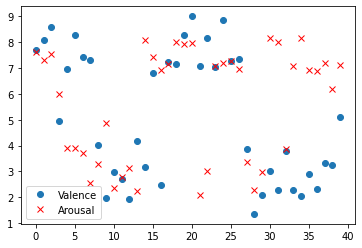

In [11]:
df_label_ratings.iloc[0:40].plot(style=['o','rx'])

In [12]:
# High Arousal Positive Valence dataset
df_hahv = df_label_ratings[(df_label_ratings['Valence'] >= np.median(labels[:,0])) & (df_label_ratings['Arousal'] >= np.median(labels[:,1]))]
# Low Arousal Positive Valence dataset
df_lahv = df_label_ratings[(df_label_ratings['Valence'] >= np.median(labels[:,0])) & (df_label_ratings['Arousal'] < np.median(labels[:,1]))]
# High Arousal Negative Valence dataset
df_halv = df_label_ratings[(df_label_ratings['Valence'] < np.median(labels[:,0])) & (df_label_ratings['Arousal'] >= np.median(labels[:,1]))]
# Low Arousal Negative Valence dataset
df_lalv = df_label_ratings[(df_label_ratings['Valence'] < np.median(labels[:,0])) & (df_label_ratings['Arousal'] < np.median(labels[:,1]))]

In [13]:

# Check nummber of trials per each group
print("Positive Valence:", str(len(df_hahv) + len(df_lahv)))
print("Negative Valence:", str(len(df_halv) + len(df_lalv)))
print("High Arousal:", str(len(df_hahv) + len(df_halv)))
print("Low Arousal:", str(len(df_lahv) + len(df_lalv)))

Positive Valence: 680
Negative Valence: 600
High Arousal: 640
Low Arousal: 640


In [14]:

# Check nummber of trials per each group
print("High Arousal Positive Valence:", str(len(df_hahv)))
print("Low Arousal Positive Valence:", str(len(df_lahv)))
print("High Arousal Negative Valence:", str(len(df_halv)))
print("Low Arousal Negative Valence:", str(len(df_lalv)))

High Arousal Positive Valence: 358
Low Arousal Positive Valence: 322
High Arousal Negative Valence: 282
Low Arousal Negative Valence: 318


In [15]:
# Get mean and std of each group
print("HAHV")
print("Valence:", "Mean", np.round(df_hahv['Valence'].mean(),2), "STD", np.round(df_hahv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_hahv['Arousal'].mean(),2), "STD", np.round(df_hahv['Arousal'].std(),2))
print()
print("LAHV:")
print("Valence:", "Mean", np.round(df_lahv['Valence'].mean(),2), "STD", np.round(df_lahv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_lahv['Arousal'].mean(),2), "STD", np.round(df_lahv['Arousal'].std(),2))
print()
print("HALV:")
print("Valence:", "Mean", np.round(df_halv['Valence'].mean(),2), "STD", np.round(df_halv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_halv['Arousal'].mean(),2), "STD", np.round(df_halv['Arousal'].std(),2))
print()
print("LALV:")
print("Valence:", "Mean", np.round(df_lalv['Valence'].mean(),2), "STD", np.round(df_lalv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_lalv['Arousal'].mean(),2), "STD", np.round(df_lalv['Arousal'].std(),2))

HAHV
Valence: Mean 7.23 STD 1.03
Arousal: Mean 6.87 STD 0.87

LAHV:
Valence: Mean 6.59 STD 1.1
Arousal: Mean 3.83 STD 1.17

HALV:
Valence: Mean 3.11 STD 1.25
Arousal: Mean 6.8 STD 0.97

LALV:
Valence: Mean 3.59 STD 1.19
Arousal: Mean 3.12 STD 1.32


In [16]:
# Function to check if each trial has positive or negative valence
def positive_valence(trial):
    return 1 if labels[trial,0] >= np.median(labels[:,0]) else 0 
# Function to check if each trial has high or low arousal
def high_arousal(trial):
    return 1 if labels[trial,1] >= np.median(labels[:,1]) else 0

In [17]:

# Convert all ratings to boolean values
labels_encoded = []
for i in range (len(labels)):
  labels_encoded.append([positive_valence(i), high_arousal(i)])
labels_encoded = np.reshape(labels_encoded, (1280, 2))
df_labels = pd.DataFrame(data=labels_encoded, columns=["Positive Valence", "High Arousal"])
print(df_labels.describe())

       Positive Valence  High Arousal
count       1280.000000   1280.000000
mean           0.531250      0.500000
std            0.499218      0.500195
min            0.000000      0.000000
25%            0.000000      0.000000
50%            1.000000      0.500000
75%            1.000000      1.000000
max            1.000000      1.000000


In [18]:
# Dataset with only Valence column
df_valence = df_labels['Positive Valence']
# Dataset with only Arousal column
df_arousal = df_labels['High Arousal']

# 频谱分析

**Welch's feature extraction**

For the EEG data, we use Welch's method to extract theta, alpha, beta, and gamma spectral power for each electrode. The frequency bands used: theta (4 - 8 Hz), alpha (8 - 12 Hz), beta (12 - 30 Hz), and gamma (30 - 64 Hz).

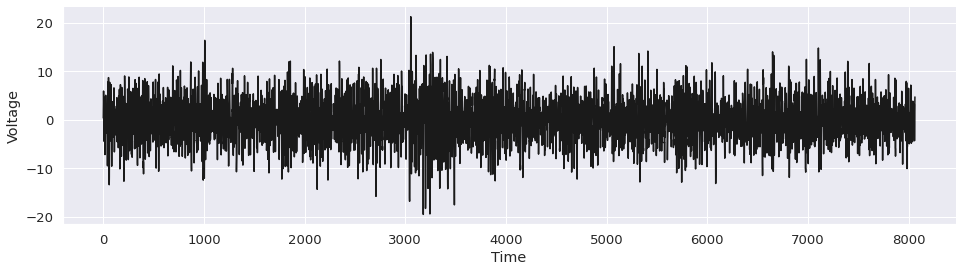

In [19]:
eeg_data=data
sns.set(font_scale=1.2)

# Define sampling frequency and time vector
sf = 128.
time = np.arange(eeg_data.size) / sf

# Plot the signal of first trial, last channel 
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(eeg_data[0,13], lw=1.5, color='k') 
plt.xlabel('Time')
plt.ylabel('Voltage')
sns.despine()

In [20]:
# Define window length (4 seconds)
win = 4 * sf
freqs, psd = signal.welch(eeg_data[0,13], sf, nperseg=win)

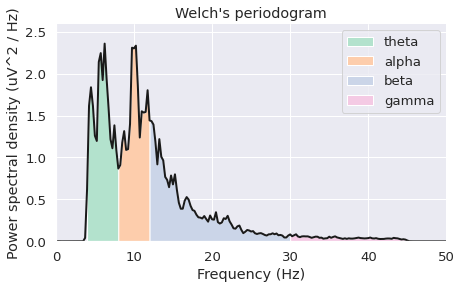

In [21]:
# Define θ α β γ
f = [4,8,12,30,64]
sns.set_palette("Pastel2", 5)
idx_theta=[]
colorss=("#51C1C8", "#E96279", "#44A2D6", "#536D84",
         "#51C1C8", "#E96279", "#44A2D6", "#536D84")
fm=["theta","alpha","beta","gamma"]
# Plot the power spectral density and fill the theta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
for i in range(4):
  # Find intersecting values in frequency vector
  idx_theta.append(np.logical_and(freqs >= f[i], freqs <= f[i+1]))
  plt.fill_between(freqs, psd, where=idx_theta[i],label=fm[i])
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

In [22]:
def bandpower(data, sf, band, window_sec=None, relative=False):
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

In [23]:
def get_band_power(trial, channel, band):
  bd = (0,0)

  if (band == "theta"): # drownsiness, emotional connection, intuition, creativity
    bd = (4,8)
  elif (band == "alpha"): # reflection, relaxation
    bd = (8,12)
  elif (band == "beta"): # concentration, problem solving, memory
    bd = (12,30)
  elif (band == "gamma"): # cognition, perception, learning, multi-tasking
    bd = (30,64)
  
  return bandpower(eeg_data[trial,channel], 128, bd)

print(get_band_power(0,13,"theta"))
print(get_band_power(0,13,"alpha"))
print(get_band_power(0,13,"beta"))
print(get_band_power(0,13,"gamma"))

5.434119660168186
5.369595513295194
6.286556266834863
0.9879159580139809


# Create EEG plots

In [26]:
info = mne.create_info(14, sfreq=128)

In [27]:
eeg_channels = np.array(["AF3","F3", "F7","FC5", "T7","P7","O1","AF4","F4","F8","FC6","T8","P8","O2"])

In [28]:
info = mne.create_info(eeg_channels.tolist(), ch_types=14*['eeg'], sfreq=128)
info.set_montage('standard_1020')
print(info)

<Info | 8 non-empty values
 bads: []
 ch_names: AF3, F3, F7, FC5, T7, P7, O1, AF4, F4, F8, FC6, T8, P8, O2
 chs: 14 EEG
 custom_ref_applied: False
 dig: 17 items (3 Cardinal, 14 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 14
 projs: []
 sfreq: 128.0 Hz
>


In [76]:
raw_data = mne.io.RawArray(eeg_data[31], info)

Creating RawArray with float64 data, n_channels=14, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.


In [ ]:
montage = mne.channels.make_standard_montage("easycap-M1")
raw_data.set_montage(montage)
montage.plot()

Effective window size : 16.000 (s)


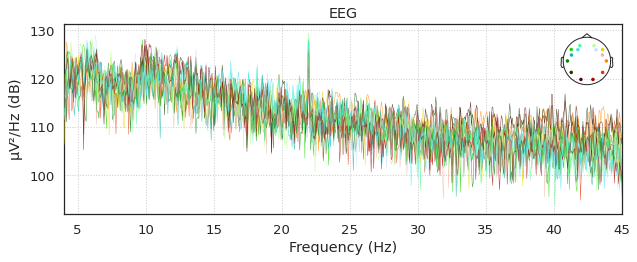

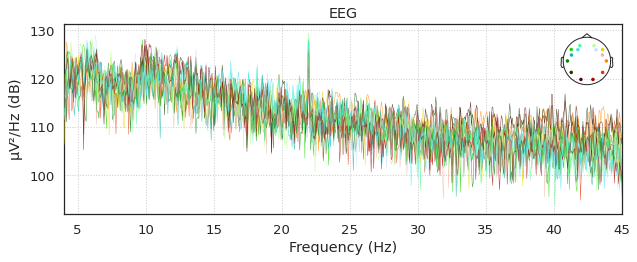

In [82]:
mne.viz.plot_raw_psd(raw_data, fmin = 4, fmax= 45)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 213 samples (1.664 sec)



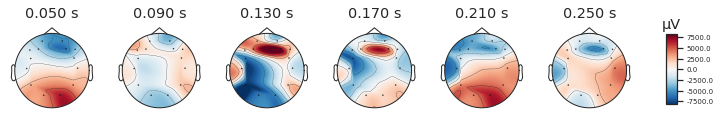

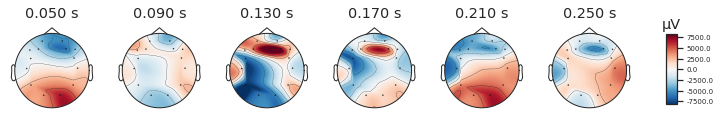

In [83]:
evData_th = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_th.filter(4, 8) 
evData_th.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 213 samples (1.664 sec)



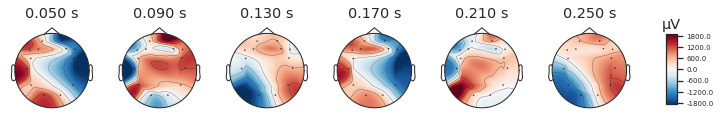

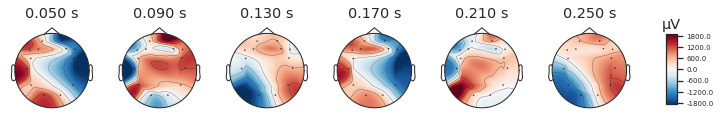

In [84]:
# Alpha band, first trial
evData_al = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_al.filter(8, 12) 
evData_al.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')

Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 141 samples (1.102 sec)



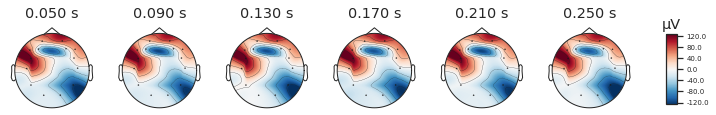

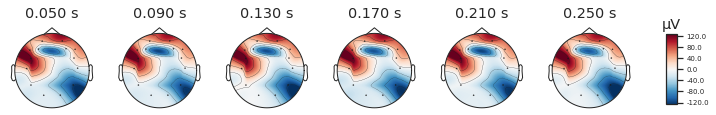

In [85]:
# Beta band, first trial
evData_bt = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_bt.filter(12, 30) 
evData_bt.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')

Setting up band-pass filter from 30 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 63.90 Hz
- Upper transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 63.95 Hz)
- Filter length: 4225 samples (33.008 sec)



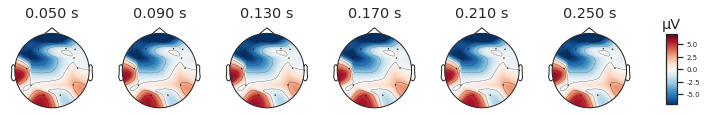

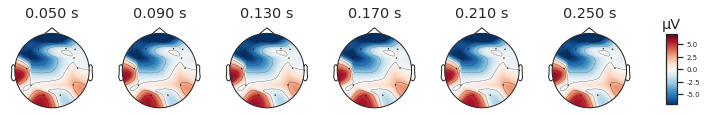

In [86]:

# Gamma band, first trial
evData_gm = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_gm.filter(30, 63.9) 
evData_gm.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')

In [87]:
ev_data_hahv = mne.EvokedArray(eeg_data[1], info)
ev_data_halv = mne.EvokedArray(eeg_data[14], info)
ev_data_lahv = mne.EvokedArray(eeg_data[6], info)
ev_data_lalv = mne.EvokedArray(eeg_data[9], info)

In [88]:
def plot_topo_psd(evData):
  evData.filter(4, 8) 
  evData.plot_topomap(0.15, ch_type='eeg', average=60, time_unit='s')

  evData.filter(8, 12) 
  evData.plot_topomap(0.15, ch_type='eeg', average=60, time_unit='s')

  evData.filter(12, 30) 
  evData.plot_topomap(0.15, ch_type='eeg', average=60, time_unit='s')

  evData.filter(30, 63.9) 
  evData.plot_topomap(0.15, ch_type='eeg', average=60, time_unit='s')

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 213 samples (1.664 sec)



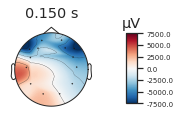

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 213 samples (1.664 sec)



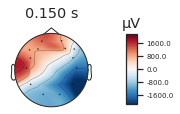

Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 141 samples (1.102 sec)



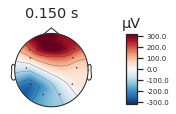

Setting up band-pass filter from 30 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 63.90 Hz
- Upper transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 63.95 Hz)
- Filter length: 4225 samples (33.008 sec)



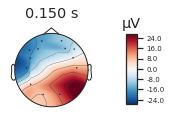

In [89]:
plot_topo_psd(ev_data_hahv)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 213 samples (1.664 sec)



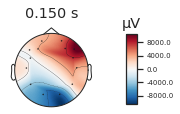

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 213 samples (1.664 sec)



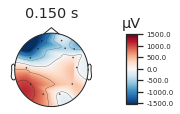

Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 141 samples (1.102 sec)



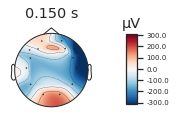

Setting up band-pass filter from 30 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 63.90 Hz
- Upper transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 63.95 Hz)
- Filter length: 4225 samples (33.008 sec)



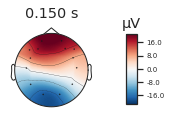

In [90]:
plot_topo_psd(ev_data_halv)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 213 samples (1.664 sec)



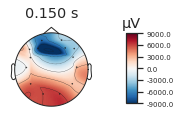

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 213 samples (1.664 sec)



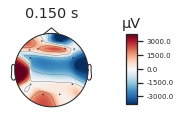

Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 141 samples (1.102 sec)



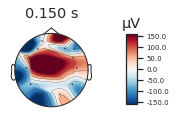

Setting up band-pass filter from 30 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 63.90 Hz
- Upper transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 63.95 Hz)
- Filter length: 4225 samples (33.008 sec)



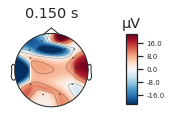

In [92]:
plot_topo_psd(ev_data_lahv)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 213 samples (1.664 sec)



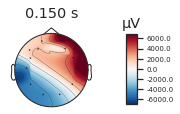

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 213 samples (1.664 sec)



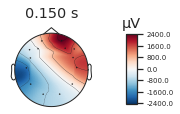

Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 141 samples (1.102 sec)



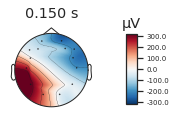

Setting up band-pass filter from 30 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 63.90 Hz
- Upper transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 63.95 Hz)
- Filter length: 4225 samples (33.008 sec)



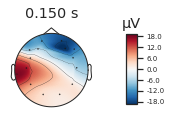

In [93]:
plot_topo_psd(ev_data_lalv)

# Process new datasets with 6 EEG regions and 4 band power values

In [24]:
# Transform 1280 x 14 x 8064 => 1280 x 128
eeg_band_arr = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_band_arr.append(get_band_power(i,j,"theta"))
    eeg_band_arr.append(get_band_power(i,j,"alpha"))
    eeg_band_arr.append(get_band_power(i,j,"beta"))
    eeg_band_arr.append(get_band_power(i,j,"gamma"))
eeg_band_arr = np.reshape(eeg_band_arr, (1280, 56))

In [48]:
left = np.array(["AF3", "F7", "FC5", "T7"])
right = np.array(["AF4", "F8", "FC6", "T8"])
frontal = np.array(["F3", "F4"])
parietal = np.array([ "P7", "P8"])
occipital = np.array(["O1", "O2"])
#central = np.array(["CP5", "CP1", "Cz", "C4", "C3", "CP6", "CP2"])

In [31]:
eeg_theta = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_theta.append(get_band_power(i,j,"theta"))
eeg_theta = np.reshape(eeg_theta, (1280, 14))

df_theta = pd.DataFrame(data = eeg_theta, columns=eeg_channels)
print(df_theta.describe())

                AF3            F3  ...           P8            O2
count   1280.000000   1280.000000  ...  1280.000000   1280.000000
mean     974.493856    795.093910  ...   222.759444    327.242856
std     3147.555132   3020.711666  ...   451.119818   1080.707954
min        1.995398      1.820656  ...     1.641482      3.681268
25%       17.117475     18.392335  ...    18.064264     19.333926
50%       82.102529     60.241953  ...    90.914662     49.630345
75%      304.949248    175.394835  ...   225.463786    113.117403
max    38122.870846  39431.320394  ...  5487.311705  12314.030522

[8 rows x 14 columns]


In [32]:
eeg_alpha = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_alpha.append(get_band_power(i,j,"alpha"))
eeg_alpha = np.reshape(eeg_alpha, (1280, 14))

df_alpha = pd.DataFrame(data = eeg_alpha, columns=eeg_channels)
print(df_alpha.describe())

                AF3            F3  ...           P8           O2
count   1280.000000   1280.000000  ...  1280.000000  1280.000000
mean     333.184883    285.545436  ...    89.003586   126.053116
std     1058.758333   1036.330438  ...   186.841170   400.465505
min        1.793012      1.724442  ...     1.212432     3.617116
25%       10.737435     10.012318  ...    10.971965    10.548845
50%       34.992442     30.026795  ...    38.758864    23.906708
75%      114.334883     73.488279  ...    88.107272    45.294454
max    12380.702125  12764.724842  ...  2323.499853  3966.714864

[8 rows x 14 columns]


In [33]:
eeg_beta = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_beta.append(get_band_power(i,j,"beta"))
eeg_beta = np.reshape(eeg_beta, (1280, 14))

df_beta = pd.DataFrame(data = eeg_beta, columns=eeg_channels)
print(df_beta.describe())

               AF3           F3  ...           P8           O2
count  1280.000000  1280.000000  ...  1280.000000  1280.000000
mean    200.684361   193.372441  ...    62.850280    90.837375
std     668.027842   668.771074  ...   134.177873   275.150372
min       2.650970     2.784376  ...     3.059450     5.084168
25%      13.190613    10.170223  ...    12.312069    11.291516
50%      29.155242    28.120517  ...    27.763129    19.688820
75%     107.619088    59.807546  ...    64.187473    36.076683
max    5784.160193  5841.475721  ...  1653.743590  2454.759737

[8 rows x 14 columns]


In [34]:
eeg_gamma = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_gamma.append(get_band_power(i,j,"gamma"))
eeg_gamma = np.reshape(eeg_gamma, (1280, 14))

df_gamma = pd.DataFrame(data = eeg_gamma, columns=eeg_channels)
print(df_gamma.describe())

               AF3           F3  ...           P8           O2
count  1280.000000  1280.000000  ...  1280.000000  1280.000000
mean    150.492372   149.210824  ...    29.805883    55.821892
std     645.635199   632.049548  ...    57.843154   203.288109
min       1.119910     0.791859  ...     0.804002     0.877576
25%       5.605668     4.352724  ...     4.513405     4.380690
50%      14.069330    11.828027  ...    10.911662     6.994829
75%      43.454610    28.586812  ...    26.489674    14.567389
max    6060.539788  5758.756812  ...   647.533599  1794.801694

[8 rows x 14 columns]


# Train-test split, feature scaling & simple training

In [35]:
def split_train_test(x, y):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)
  return x_train, x_test, y_train, y_test

In [36]:
# Feature scaling
def feature_scaling(train, test):
  sc = StandardScaler()
  train = sc.fit_transform(train)
  test = sc.transform(test)
  return train, test

In [55]:
band_names = np.array(["theta", "alpha", "beta", "gamma"])
channel_names = np.array(["left", "frontal", "right",  "parietal", "occipital"])
label_names = np.array(["valence", "arousal"])

In [38]:
clf_svm = SVC(kernel = 'linear', random_state = 42, probability=True)

In [39]:
clf_knn = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto')

In [40]:
clf_mlp = MLPClassifier(solver='adam', activation='tanh', alpha=0.3, max_iter=400)

In [41]:
models = []
models.append(('SVM', clf_svm))
models.append(('k-NN', clf_knn))
models.append(('MLP', clf_mlp))

In [42]:
import time
def cross_validate_clf(df_x, df_y, scoring):
  # Train-test split 
  x_train, x_test, y_train, y_test = split_train_test(df_x, df_y)
  # Feature scaling
  x_train, x_test = feature_scaling(x_train, x_test)

  names = []
  means = []
  stds = []
  times = []

  # Apply CV
  for name, model in models:
      start_time = time.time()
      kfold = model_selection.KFold(n_splits=5)
      cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
      t = (time.time() - start_time)
      times.append(t)
      means.append(cv_results.mean())
      stds.append(cv_results.std())
      names.append(name)

  return names, means, stds, times

In [43]:
cross_validate_clf(eeg_band_arr, df_arousal, 'accuracy')

(['SVM', 'k-NN', 'MLP'],
 [0.5681191806331471, 0.6127250155183116, 0.5747672253258845],
 [0.0512759222297073, 0.009629159245023125, 0.022056625629896107],
 [0.9050536155700684, 0.055068254470825195, 7.244009017944336])

In [51]:
def run_clf_cv(band, channel, label, clf):
  if (band == "theta"):
    df_x = df_theta
  elif (band == "alpha"):
    df_x = df_alpha
  elif (band == "beta"):
    df_x = df_beta
  elif (band == "gamma"):
    df_x = df_gamma

  if (channel == "left"):
    df_x = df_x[left]
  elif (channel == "right"):
    df_x = df_x[right]
  elif (channel == "frontal"):
    df_x = df_x[frontal]
  elif (channel == "parietal"):
    df_x = df_x[parietal]
  elif (channel == "occipital"):
    df_x = df_x[occipital]

  df_y = df_arousal if (label == "arousal") else df_valence

  # Train-test split
  x_train, x_test, y_train, y_test = split_train_test(df_x, df_y)
  
  # Apply CV
  x_for_kfold = np.array(x_train)            
  y_for_kfold = np.array(y_train)
  kfold = model_selection.KFold(n_splits=5)

  for i, j in kfold.split(x_for_kfold):
   x_train2, x_test2 = x_for_kfold[i], x_for_kfold[j]
   y_train2, y_test2 = y_for_kfold[i], y_for_kfold[j]
  
  # Feature scaling
  x_train2, x_test2 = feature_scaling(x_train2, x_test2)

  if (clf == "svm"):
    clf_svm.fit(x_train2, y_train2)
    y_predict = clf_svm.predict(x_test2)
  elif (clf == "knn"):
    clf_knn.fit(x_train2, y_train2)
    y_predict = clf_knn.predict(x_test2)
  elif (clf == "mlp"):
    clf_mlp.fit(x_train2, y_train2)
    y_predict = clf_mlp.predict(x_test2)

  return y_test2, y_predict

In [52]:
def get_accuracy(band, channel, label, clf):
  y_test2, y_predict = run_clf_cv(band, channel, label, clf)
  return np.round(accuracy_score(y_test2, y_predict)*100,2)

In [57]:
def print_accuracy(label, clf):
  arr = []
  for i in range (len(band_names)):
    for j in range (len(channel_names)): 
      arr.append(get_accuracy(band_names[i], channel_names[j], label, clf))
  arr = np.reshape(arr, (4,5))
  df = pd.DataFrame(data = arr, index=band_names, columns=channel_names)

  print("Top 3 EEG regions with highest scores")
  print(df.apply(lambda s: s.abs()).max().nlargest(3))
  print()
  print("Top 2 bands with highest scores")
  print(df.apply(lambda s: s.abs()).max(axis=1).nlargest(2))
  print()
  print("EEG region with highest scores per each band")
  print(df.idxmax(axis=1))
  print()
  print("Band with highest scores per each EEG region")
  print(df.idxmax())
  print()
  print(df)

In [58]:
print_accuracy('valence', 'knn')

Top 3 EEG regions with highest scores
left         63.13
right        63.13
occipital    61.45
dtype: float64

Top 2 bands with highest scores
beta     63.13
gamma    63.13
dtype: float64

EEG region with highest scores per each band
theta    frontal
alpha      right
beta        left
gamma       left
dtype: object

Band with highest scores per each EEG region
left          beta
frontal       beta
right        gamma
parietal      beta
occipital    gamma
dtype: object

        left  frontal  right  parietal  occipital
theta  54.19    59.22  50.28     47.49      48.04
alpha  54.19    50.84  55.87     49.72      51.40
beta   63.13    60.89  60.89     54.19      52.51
gamma  63.13    58.10  63.13     53.63      61.45


In [60]:
print_accuracy('arousal', 'knn')

Top 3 EEG regions with highest scores
right      62.01
frontal    61.45
left       60.34
dtype: float64

Top 2 bands with highest scores
alpha    62.01
theta    60.89
dtype: float64

EEG region with highest scores per each band
theta      right
alpha      right
beta     frontal
gamma      right
dtype: object

Band with highest scores per each EEG region
left         alpha
frontal      alpha
right        alpha
parietal     alpha
occipital    theta
dtype: object

        left  frontal  right  parietal  occipital
theta  58.66    60.34  60.89     51.40      58.66
alpha  60.34    61.45  62.01     56.98      56.98
beta   58.10    59.22  58.66     56.98      47.49
gamma  53.07    53.07  56.98     50.28      53.63


# My Data

In [62]:
pd.read_excel("/content/drive/MyDrive/EEG Raw Data/Trail1.xlsx",header=1)

,Timestamp,Unnamed: 1,EEG.Counter,EEG.Interpolated,EEG.AF3,EEG.F7,EEG.F3,EEG.FC5,EEG.T7,EEG.P7,EEG.O1,EEG.O2,EEG.P8,EEG.T8,EEG.FC6,EEG.F4,EEG.F8,EEG.AF4,EEG.RawCq,EEG.Battery,EEG.BatteryPercent,MarkerIndex,MarkerType,MarkerValueInt,EEG.MarkerHardware,CQ.AF3,CQ.F7,CQ.F3,CQ.FC5,CQ.T7,CQ.P7,CQ.O1,CQ.O2,CQ.P8,CQ.T8,CQ.FC6,CQ.F4,CQ.F8,CQ.AF4,CQ.Overall,...,POW.O1.Theta,POW.O1.Alpha,POW.O1.BetaL,POW.O1.BetaH,POW.O1.Gamma,POW.O2.Theta,POW.O2.Alpha,POW.O2.BetaL,POW.O2.BetaH,POW.O2.Gamma,POW.P8.Theta,POW.P8.Alpha,POW.P8.BetaL,POW.P8.BetaH,POW.P8.Gamma,POW.T8.Theta,POW.T8.Alpha,POW.T8.BetaL,POW.T8.BetaH,POW.T8.Gamma,POW.FC6.Theta,POW.FC6.Alpha,POW.FC6.BetaL,POW.FC6.BetaH,POW.FC6.Gamma,POW.F4.Theta,POW.F4.Alpha,POW.F4.BetaL,POW.F4.BetaH,POW.F4.Gamma,POW.F8.Theta,POW.F8.Alpha,POW.F8.BetaL,POW.F8.BetaH,POW.F8.Gamma,POW.AF4.Theta,POW.AF4.Alpha,POW.AF4.BetaL,POW.AF4.BetaH,POW.AF4.Gamma
0,1629270987,15:16:27,31,0,4235.000000,4576.410156,4250.641113,4536.922852,4289.615234,4313.205078,4310.641113,4280.641113,4301.666504,4289.487305,4471.666504,4326.025879,4306.538574,4351.794922,0,4,97,NaN,NaN,NaN,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1629270987,15:16:27,32,0,4259.102539,4597.307617,4275.641113,4573.846191,4290.384766,4328.205078,4339.743652,4309.358887,4331.794922,4331.538574,4552.436035,4348.717773,4301.794922,4401.538574,0,4,97,NaN,NaN,NaN,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1629270987,15:16:27,33,0,4271.025879,4596.153809,4297.307617,4603.333496,4287.948730,4332.436035,4336.666504,4310.000000,4331.282227,4318.461426,4495.512695,4337.179688,4291.153809,4393.461426,0,4,97,NaN,NaN,NaN,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1629270987,15:16:27,34,0,4275.000000,4598.205078,4292.436035,4569.615234,4314.743652,4330.384766,4321.025879,4300.128418,4325.769043,4327.692383,4492.307617,4333.077148,4327.179688,4375.384766,0,4,97,NaN,NaN,NaN,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1629270987,15:16:27,35,0,4295.128418,4627.692383,4298.974121,4560.000000,4350.897461,4337.948730,4333.717773,4309.102539,4343.717773,4361.025879,4559.230957,4337.692383,4373.461426,4393.205078,0,4,97,NaN,NaN,NaN,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7807,1629271047,15:17:27,30,0,4624.743652,5241.410156,4543.461426,4925.128418,4648.589844,4486.794922,4549.358887,4552.051270,4528.333496,4496.666504,4647.307617,4554.743652,4568.461426,4596.922852,0,4,97,NaN,NaN,NaN,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7808,1629271047,15:17:27,31,0,4612.307617,5213.205078,4496.666504,4954.615234,4626.794922,4474.358887,4514.358887,4513.974121,4502.948730,4473.717773,4615.256348,4525.256348,4550.256348,4562.820313,0,4,97,NaN,NaN,NaN,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

# past

In [ ]:
#@title

def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open('/content/drive/MyDrive/data_preprocessed_python/s' + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0;

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                #print(len(channel))
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                    Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                    meta_data = meta_data + list(Y[0])

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)

                meta.append(np.array(meta_array))    
                start = start + step_size
                #print(np.array(meta_array).shape)        
        meta = np.array(meta)
        np.save('out\s' + sub, meta, allow_pickle=True, fix_imports=True)

def testing (M, L, model):
    '''
    arguments:  M: testing dataset
                L: testing dataset label
                model: scikit-learn model

    return:     void
    '''
    output = model.predict(M[0:78080:32])
    label = L[0:78080:32]

    k = 0
    l = 0

    for i in range(len(label)):
        k = k + (output[i] - label[i])*(output[i] - label[i]) #square difference 

        #a good guess
        if (output[i] > 5 and label[i] > 5):
            l = l + 1
        elif (output[i] < 5 and label[i] <5):
            l = l + 1

    print ("l2 error:", k/len(label), "classification accuracy:", l / len(label),l, len(label))

In [ ]:
#@title
for subjects in subjectList:
    FFT_Processing (subjects, channel, band, window_size, step_size, sample_rate)

In [ ]:
#@title
with open('/content/drive/MyDrive/data_preprocessed_python/s' + "01" + '.dat', 'rb') as file:
  subject = pickle.load(file, encoding='latin1')
  print(subject["labels"].shape)
  print(subject["data"].shape)

In [ ]:
#@title
with open('out\s01.npy', 'rb') as file:
  sub = np.load(file, allow_pickle=True)

In [ ]:
#@title
#for subjects in subjectList:
data_training = []
label_training = []
data_testing = []
label_testing = []
data_validation = []
label_validation = []

for subjects in subjectList:

    with open('out\s' + subjects + '.npy', 'rb') as file:
        sub = np.load(file, allow_pickle=True)
        for i in range (0,sub.shape[0]):
            if i % 8 == 0:
                data_testing.append(sub[i][0])
                label_testing.append(sub[i][1])
            elif i % 8 == 1:
                data_validation.append(sub[i][0])
                label_validation.append(sub[i][1])
            else:
                data_training.append(sub[i][0])
                label_training.append(sub[i][1])

np.save('out\data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save('out\label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save('out\data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save('out\label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

np.save('out\data_validation', np.array(data_validation), allow_pickle=True, fix_imports=True)
np.save('out\label_validation', np.array(label_validation), allow_pickle=True, fix_imports=True)
print("validation dataset:", np.array(data_validation).shape, np.array(label_validation).shape)

training dataset: (468480, 70) (468480, 4)
testing dataset: (78080, 70) (78080, 4)
validation dataset: (78080, 70) (78080, 4)


In [ ]:
#@title
with open('out\data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)
    
with open('out\label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)
    
X = normalize(X)
Z = np.ravel(Y[:, [1]])

Arousal_Train = np.ravel(Y[:, [0]])
Valence_Train = np.ravel(Y[:, [1]])
Domain_Train = np.ravel(Y[:, [2]])
Like_Train = np.ravel(Y[:, [3]])



with open('out\data_validation.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)
    
with open('out\label_validation.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)

M = normalize(M)
L = np.ravel(N[:, [1]])

Arousal_Test = np.ravel(N[:, [0]])
Valence_Test = np.ravel(N[:, [1]])
Domain_Test = np.ravel(N[:, [2]])
Like_Test = np.ravel(N[:, [3]])

In [ ]:
#@title

Val_R = RandomForestRegressor(n_estimators=512, n_jobs=6)
Val_R.fit(X[1:468480:32], Valence_Train[1:468480:32])
testing (M, Valence_Test, Val_R)